# DL Assignment 2 - Adversarial Attacks, Fully Convolutional Networks, Class Activation Mapping

Welcome to the second assignment of the DL course 2020! In the last labs we were discussing the task of image classification. You implemented neural networks in Numpy, designed and trained a ConvNet from scratch, added regularization techniques, and used pre-trained models for transfer learning and fine-tuning. Next, you explored different ways to visualize what a ConvNet has learned and which information it consumes in order to make a prediction.

In **Assignment 2**, you will use an approach to trick a ConvNet into making wrong predictions, i.e., so called **adversarial attacks**.
Furthermore, you will go beyond image classification and implement different approaches to also **localize** an object, e.g., a flower ;), in an image. 
Considering the presence of more than one object, you will implement different approaches for **object detection**.

**After completing this assignment, you will have**
- learned how to attack neural networks by **adversarial examples**.
- implemented two **sliding window** approaches for object detection.
- learned how to transform networks into **fully convolutional networks**.
- learned how to interprete ConvNets using **class activation mapping**.
- used **YOLOv3** for object detection.

**Instructions**
- You'll be using Python 3 in the iPython based Google Colaboratory
- Lines encapsulated in "<font color='green'>`### START YOUR CODE HERE ###`</font>" and "<font color='green'>`### END YOUR CODE HERE ###`</font>" denote the code fragments to be completed by you.
- There's no need to write any other code.
- After writing your code, you can run the cell by either pressing `SHIFT`+`ENTER` or by clicking on the play symbol on the left side of the cell.
- We may specify "<font color='green'>`(≈ X LOC)`</font>" to tell you about how many lines of code you need to write. This is just a rough estimate, so don't feel bad if your code is longer or shorter.


**Much success!**

<font color='darkblue'>
  
**Remember**  
- Run your cells using `SHIFT`+`ENTER` (or "Run cell")
- Write code in the designated areas using Python 3 only
- Do not modify the code outside of the designated areas
- Do not import/use any other packages. Code relying on packages other than the provided ones won't be graded.
- Activate GPU acceleration by clicking `Runtime` -> `Change runtime type` and select `GPU` from the dropdown menu entitled `Hardware accelerator`
</font>

***

# 0 - Test for GPU

Execute the code below for printing the TF version and testing for GPU availability.

In [1]:
#@title Print TF version and GPU stats
import tensorflow as tf
import sys
print('TensorFlow version:', tf.__version__)

device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
   raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name), '', sep='\n')
!nvidia-smi

TensorFlow version: 2.3.0
Found GPU at: /device:GPU:0

Wed Nov 25 00:17:29 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 455.38       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   48C    P0    35W / 250W |    359MiB / 16280MiB |      6%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                 

In [2]:
#@title Download and import `utils` for Assignment 2

import requests, os, zipfile
import numpy as np

def download_file_from_google_drive(id, destination):
    URL = "https://docs.google.com/uc?export=download"
    session = requests.Session()
    response = session.get(URL, params = { 'id' : id }, stream = True)
    token = get_confirm_token(response)
    if token:
        params = { 'id' : id, 'confirm' : token }
        response = session.get(URL, params = params, stream = True)
    save_response_content(response, destination)    

def get_confirm_token(response):
    for key, value in response.cookies.items():
        if key.startswith('download_warning'):
            return value
    return None

def save_response_content(response, destination):
    CHUNK_SIZE = 32768
    with open(destination, "wb") as f:
        for chunk in response.iter_content(CHUNK_SIZE):
            if chunk: # filter out keep-alive new chunks
                f.write(chunk)

# download utils
download_file_from_google_drive('1WYTduftimsNEPmy9yTRU5YEIRywZezW1', '/content/utils.py')
download_file_from_google_drive('1A9bb4igGvgQHmizGUQevSEwsO_jR_sDn', '/content/testimage_detection.jpg')

import utils

# Part 1 - Adversarial Attacks

In DL Lab 2.2, we discussed **activation maximization**, i.e., updating input image pixels using gradient ascent in order to maximize the activation of a specific convolution filter or neuron. This way, you created somewhat convoluted visualizations of what your ConvNet was actually looking for in images.

You can use a similar idea, i.e., learn how to adjust the input of any classifier in order to enforce a specific output, for attacking a neural network and fooling it into making wrong predictions. The core idea of such carefully designed **adversarial attacks** was first proposed by [Ian Goodfellow et al. in 2014](https://arxiv.org/abs/1412.6572) and represents the first part of Assignment 2.

In [3]:
from tensorflow.keras import layers, Model
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import backend as K
from tensorflow.keras.regularizers import l2
from tensorflow.keras.utils import get_custom_objects, plot_model
from tensorflow.keras.callbacks import EarlyStopping

from scipy.ndimage import zoom
from skimage import filters
from matplotlib import pyplot as plt

The dataset is provided via `utils.load_dataset()`:

In [4]:
train_generator, validation_generator, train_steps, validation_steps, num_classes = utils.load_dataset('flowers10')

Found 800 images belonging to 10 classes.
Found 200 images belonging to 10 classes.


## 1.1 - Prepare Attacks

You will attack the VGG16 model that you already know from DL Lab 2.2. However, you will top layers that are slightly different compared to the version from DL Lab 2.2. In detail:
- Add a [`Flatten` layer](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Flatten) on top of the output of the pre-trained VGG16 (without top layers).
- Add a dense layer with 1024 neurons, ReLU activation, and 20% dropout rate.
- Add a dense layer with `num_classes` neurons with softmax activation for classification. The output of this last dense layer shall be output of your model.

**Task**: Complete the code below to define the architecture and compile the model.

In [5]:
# GRADED FUNCTION: build_from_pretrained (2.5 points)
def build_from_pretrained( num_classes, input_shape=(150,150,3), init_lr=1e-4 ):

  pre_trained_model = VGG16(input_shape=input_shape,
                            weights='imagenet',
                            include_top=False)
  
  ### START YOUR CODE HERE ### (≈ 5 LOC)
  x = layers.Flatten()(pre_trained_model.output)
  x = layers.Dense(1024, activation='relu')(x)
  x = layers.Dropout(0.2)(x)
  output = layers.Dense(num_classes, activation='softmax')(x)
  model = Model(pre_trained_model.input, output)

    
  ### END YOUR CODE HERE ###

  # Compile the model
  model.compile(loss='categorical_crossentropy',
                optimizer=Adam(lr=init_lr),
                metrics=['accuracy'])

  return model, pre_trained_model

Create an instance of the pretrained model

In [6]:
classifier_model, pre_trained_model = build_from_pretrained(num_classes)
print(classifier_model.summary())

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)      

The cell below downloads weights from a provided checkpoint to the path `ckp_path`.

In [7]:
#@title Download checkpoint model weights

ckp_path = '/tmp/checkpoints/fi_flowers_vgg16_fine_tuned'
os.makedirs(ckp_path, exist_ok=True)

while not os.path.isfile(os.path.join(ckp_path, 'checkpoint')):
  print('Downloading checkpoint')
  # download and unzip
  download_file_from_google_drive('1k-6fdJDix-ot3qxRr22p01VkfQUjJUSk', os.path.join(ckp_path, 'model.zip'))
  utils.unzip( os.path.join(ckp_path, 'model.zip'), os.path.dirname(ckp_path) )

ckp_path = os.path.join(ckp_path, 'model')

**Task**: Complete the function `restore_weights()` for loading the weights from the downloaded checkpoint into your [model](https://www.tensorflow.org/api_docs/python/tf/keras/Model).

**Note**: The cell will raise an error if the restored model's architecture is different from your model architecture. In that case correct your architecture for the specifications detailed above.

In [8]:
# GRADED FUNCTION: restore_weights (1 point)
def restore_weights(model, ckp_path):
  ''' Restore all model weights from weights file provided by `ckp_path`.
  Weights are loaded based on network topology.
  
  Arguments
  ------------
    model : instance of tf.keras.Model
    ckp_path : path to weights file

  Returns
  ------------
  model : model with loaded weights
  '''

  ### START YOUR CODE HERE ### (≈1 LOC)
  model.load_weights(ckp_path)
  ### END YOUR CODE HERE ###
  
  return model

# Load the weights
classifier_model = restore_weights(classifier_model, ckp_path)

Evaluation of the restored model on the validation data should give 97% accuracy:

In [9]:
_, accuracy = classifier_model.evaluate(validation_generator)
print('\nAccuracy: {:.2f}%'.format(accuracy*100))

7/7 [==============================] - 1s 75ms/step - loss: 0.1729 - accuracy: 0.9700

Accuracy: 97.00%


Let's build a function for printing a model's prediction on a given image.

**Task**: Complete the function `print_prediction()`. The function shall print the index of the predicted class along with its softmax probability.

**Note**: Check `classifier_model.input_shape` if you are unsure about the input shape.

In [10]:

# GRADED FUNCTION: print_prediction (1 point)
def print_prediction(model, img):
  ''' Compute model prediction for input `img` and print index and probability for predicted class.
    
  Arguments
  ------------
    model : classification model
    img : input image
  '''
  
  ### START YOUR CODE HERE ### (≈2 LOC)
  img = np.expand_dims(img, axis = 0)
  probabilities = model.predict(img).flatten()
  predicted_class_idx = np.argmax(probabilities)
  ### END YOUR CODE HERE ###  

  print('Prediction: Class {} ({:.2f}%)'.format(predicted_class_idx, probabilities[predicted_class_idx]*100))



## 1.2 - Random Noise Attacks

You are now ready to begin some **attacks**! Let's see if some normally distributed random noise fools the classifier:

In [11]:
def add_random_noise(img):
  noise = np.random.normal(loc=0.0, scale=0.2, size=img.shape)
  return np.clip(img + noise, 0., 1.)

def eval_random_noise_attack(img, model):
  utils.show(img, figsize=(5,5))
  print_prediction(model, img)
  
  # Generate normally distributed noise
  img = add_random_noise(img)

  utils.show(img, figsize=(5,5))
  print_prediction(model, img)

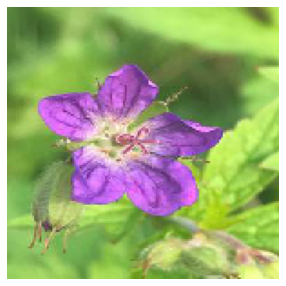

Prediction: Class 0 (100.00%)


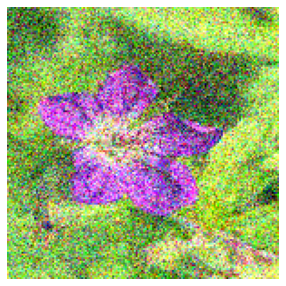

Prediction: Class 0 (98.73%)


In [12]:
# Get a new image from the validation set
img, onehot_class = [items[-1] for items in validation_generator.next()]

# Evaluate the attack
eval_random_noise_attack(img, classifier_model)

Repeat the attack a few times. Even if the images appear pretty perturbed to us, the classifier seems to be rather resilient against such simple attacks.

## 1.3 - Adversarial Attacks

Let's see if you can modify the same image to be an **adversarial example**. To do so, you will create a new model called `adversarial_model`. This model shall learn to modify the input image before feeding it through the `classifier_model`. The adversarial model basically consists of one dense layer. This layer learns additive input patterns that cause the original classification model to predict a certain class predefined by us. In order to add the adversarial patterns, the output size of the dense layer needs to match the number of pixels of the input image.

The architecture of the model can be plotted using the `plot_model` method in the `keras.utils` module. You should see two inputs, `unity` and `original_image`. The `activation` should then be fed into the original classifier model. **Make sure the classifier model has no trainable parameters.** The adversarial model's architecture shall look like this:
<figure>
<center>
<img src='https://www.tu-ilmenau.de/fileadmin/media/SECSY/storage/adv_model.png' width='360' />
<figcaption>Expected model architecture</figcaption></center>
</figure>

**Task**: Complete the function `build_adversarial_model()` to define the architecture and compile the adversarial model. 
The model to be attacked, i.e., the original model, is provided as `classifier_model` argument.

**Note**: In order to make this idea work, the original model must be prevented from learning anything. Otherwise it will learn to mitigate the modifications introduced by the adversarial model.

**Note$^2$**: Check the documentation of the [tf.keras.layers](https://www.tensorflow.org/api_docs/python/tf/keras/layers) module for layers like `Reshape` and `Add`.

In [13]:
# GRADED FUNCTION: build_adversarial_model (3.5 points)
def build_adversarial_model(img, classifier_model, learning_rate=.01):

  # Add `clip` to dictionary of custom objects
  get_custom_objects().update({'clip': layers.Activation(clip)})

  ### START YOUR CODE HERE ### (7 LOC)

  # Freeze the classifier_model
  classifier_model.trainable = False


  # Input layer for the image fed into adversarial model
  image = layers.Input(name='original_image',
                       shape= img.shape
                       )
  
  # Another input for the adversarial noise
  one = layers.Input(shape=(1,), name='unity')

  # Dense layer for learning the adversarial noise
  noise = layers.Dense(img.shape[0]*img.shape[1]*img.shape[2],
                       activation=None,
                       use_bias=False,
                       kernel_initializer='random_normal',
                       kernel_regularizer=l2(.1),
                       name='adversarial_noise'
                       )(one)

  # Reshape the noise to the shape of image
  noise = layers.Reshape(img.shape, name ="reshape")(noise)

  # Add noise to image to create adversarial image
  x = layers.Add(name='add')([noise,image])

  # Clip values of adversarial image to [0, 1]
  x = layers.Activation('clip')(x)

  # Feed adversarial image to original classifier model
  
  output = classifier_model(x)



  # Define the adversarial model
  adversarial_model = Model(inputs=[image, one],
                            outputs= output
                            )
  
  ### END YOUR CODE HERE ###

  # Compile the adversarial model
  adversarial_model.compile(loss='categorical_crossentropy',
                            optimizer=Adam(lr=learning_rate),
                            metrics=['accuracy'])

  return adversarial_model

def clip(x):
  '''Custom activation function for clipping adversarial pixel values.'''
  return K.clip(x, 0., 1.)

Classifier model's trainable parameters: 0


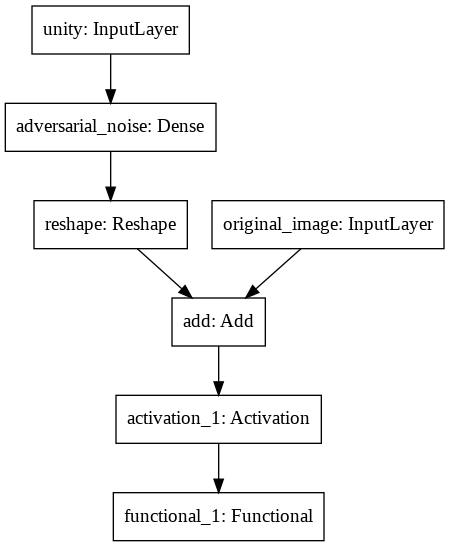

In [14]:
adversarial_model = build_adversarial_model(img, classifier_model)
print("Classifier model's trainable parameters:",  len(classifier_model.trainable_weights))
plot_model(adversarial_model)

In [15]:
print(adversarial_model.summary())

Model: "functional_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
unity (InputLayer)              [(None, 1)]          0                                            
__________________________________________________________________________________________________
adversarial_noise (Dense)       (None, 67500)        67500       unity[0][0]                      
__________________________________________________________________________________________________
reshape (Reshape)               (None, 150, 150, 3)  0           adversarial_noise[0][0]          
__________________________________________________________________________________________________
original_image (InputLayer)     [(None, 150, 150, 3) 0                                            
_______________________________________________________________________________________

Next, you tell adversarial model to modify the input image so that the classification model gets tricked into predicting the class defined by `target_class_idx`. 

**Task**: Complete the function `create_target_output()` returning a one-hot encoded output vector of length `num_classes` that defines the adversarial output probability distribution. The elements in `target_vector` shall be zero everywhere except for the element at index `target_class_idx`, which shall be `1`.

In [16]:
# GRADED FUNCTION: create_target_output (1 point)
def create_target_output(target_class_idx, num_classes):
  ''' Create one-hot encoded class vector as target probability vector.
  Elements of the returned vector are `1` at index `target_class_idx`
  and 0 everywhere else.
  
  Arguments
  ------------
    target_class_idx : index of target class
    num_classes : number of classes (length of returned vector)

  Returns
  ------------
  target_vector : one-hot encoded class vector
  '''

  ### START YOUR CODE HERE ### (≈ 2 LOC)
  target_vector = np.zeros((num_classes), dtype=np.float32)
  target_vector[target_class_idx] = 1
  ### END YOUR CODE HERE ###
  
  return target_vector

In [17]:
print(create_target_output(3, 10))
# expected output: [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]

[0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]


Next, we create some helper functions to actually train and evaluate the adversarial model for an input model and image.

In [18]:
def add_adversarial_noise(img, classifier_model, target_class_idx, num_classes):

  adversarial_model = build_adversarial_model(img, classifier_model)
  target_vector = create_target_output(target_class_idx, num_classes)
  
  # add early stopping to interrupt training if loss stops decreasing
  early_stop = EarlyStopping(monitor='loss', 
                             patience=10,
                             verbose=0,
                             restore_best_weights=True)

  adversarial_model.fit(x={'original_image':np.expand_dims(img, 0), 'unity':np.ones(shape=(1, 1))},
                        y=target_vector.reshape(1,-1),
                        epochs=100,
                        verbose=0,
                        callbacks=[early_stop])

  quantized_weights = np.round( adversarial_model.get_weights()[0].reshape(img.shape) * 255.) / 255.

  # add trained weights to original image and clip values to produce adversarial image
  adversarial_img = np.clip(img + quantized_weights, 0., 1.)
  
  return adversarial_img, quantized_weights

def eval_adversarial_noise_attack(img, classifier_model, target_class_idx, num_classes):

  utils.show(img, figsize=(5,5))
  print_prediction(classifier_model, img)
  
  # Generate adversarial noise
  img, adversarial_noise = add_adversarial_noise(img, classifier_model, target_class_idx, num_classes)

  utils.show(img, figsize=(5,5))
  print_prediction(classifier_model, img)

  adversarial_noise -= np.min(adversarial_noise)
  adversarial_noise /= np.max(adversarial_noise)
  utils.show(adversarial_noise, figsize=(5,5))

Let's see if your adversarial model successfully attacks the `classifier_model`.

You may further test more images by executing 

`img, onehot_class = [items[-1] for items in validation_generator.next()]` 

prior to evaluation.

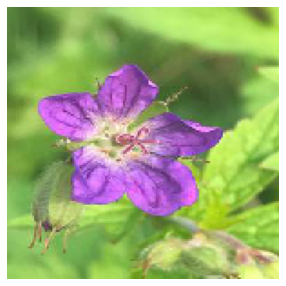

Prediction: Class 0 (100.00%)


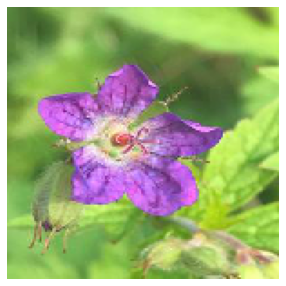

Prediction: Class 7 (77.94%)


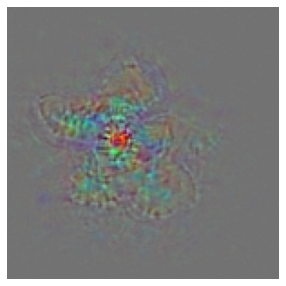

In [19]:
eval_adversarial_noise_attack(img, 
                              classifier_model, 
                              # define target class index or select random:
                              np.random.choice(list(validation_generator.class_indices.values()), p=np.logical_not(onehot_class)/(num_classes-1)),
                              num_classes)

If you did everything right, you should see three images:
1. The original image,
2. the adversarial image, and
3. the min-max normalized adversarial noise added to the original image.

As you see, fooling a classifier by generating adversarial noise is very simple. The adversarial noise is much less visible to us compared to random noise. Yet, those barely visible changes trick the classifier into making wrong predictions!

---

# Part 2 - Object Detection

Let's consider we want to re-use our neural network classifier for performing detection on novel images, e.g., the following one:

Image of size (1067, 1600)


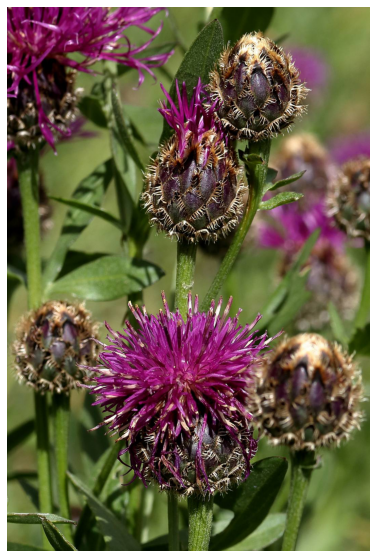

In [20]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array

img_path = 'testimage_detection.jpg'

test_img = load_img(img_path)
print('Image of size', test_img.size)
utils.show(test_img, figsize=(10,10))

The image has $1067 \times 1600$ px, hence it is considerably larger compared to the input size of the classifier network. To feed it through the classifier network, we need to resize the image to match the input size, i.e., $150 \times 150$ px:

In [21]:
# Resize and normalize the image
img = img_to_array(test_img.resize( (150, 150) )) / 255.
print_prediction(classifier_model, img)

Prediction: Class 1 (84.83%)


The classifier predicts the image to display "class 1" (*Arctium tomentosum*) with 84.8% softmax probability, which is actually wrong. The correct prediction would be "Class 8" (*Centaurea scabiosa*), which achieves only 14.9% softmax probability.

To get an idea on why the classifier predicts *Arctium tomentosum*, we could analyze **where** the network predicts *Arctium tomentosum* (and, of course, also *Centaurea scabiosa*).

The image is considerably larger than the input size of the network. The most simple and straight-forward approach for **localization** or **detection** is to extract a series of patches from a sliding window. We resize every patch to match the input size and eventually feed them through the network to compute predictions for every patch.

## 2.1 - Sliding Window

In this approach, we will combine your classifier with some traditional programming. We will split the images into overlapping patches and feed each patch into the network for classification. In order to speed up the computations, we create a batch of patches to be forwarded through the network in parallel.

**Task**: Complete the function `eval_crops_batch()` for forwarding a `batch` of images through the network and returning a 3D tensor `pmap` of probabilities. The shape of `pmap` has to be `(grid_shape[0], grid_shape[1], num_classes)`.

In [22]:
# GRADED FUNCTION: eval_crops_batch (1 point)
def eval_crops_batch(model, batch, grid_shape):
  ''' Forward batch through model and return probability maps for each class.
  
  Arguments
  ------------
    model : classification model
    batch : minibatch of input samples
    grid_shape : (height, width) of output probability map

  Returns
  ------------
  pmap : probability map of shape (height, width, num_classes)
  '''

  print('Forwarding {} patches'.format(batch.shape[0]))

  ### START YOUR CODE HERE ### (≈ 2 LOC)  
  
  # Forward batch through model to make predictions
  predictions = model.predict(batch)
  # Reshape flat output probabilities to a xy-grid of probabilities
  pmap = predictions.reshape(grid_shape[0], grid_shape[1], num_classes)

  ### END YOUR CODE HERE ###
  
  return pmap

Now, let's use the original image and extract patches from a grid of $300 \times 300$ windows with 75% overlap and feed them through the network. A vector of probabilities is then returned for every cell of the grid, i.e., a probability map `pmap`.

Creating batch of 18 x 11 patches
Forwarding 198 patches


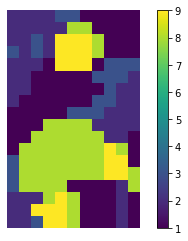

CPU times: user 3.07 s, sys: 2.14 s, total: 5.21 s
Wall time: 2.99 s


In [23]:
%%time
# Resize and normalize the image
img = img_to_array(test_img) / 255.

# Crop overlapping patches and create batch
batch, grid_shape = utils.img_crops_to_batch(img, window_size=300)

# Forward batch through network to obtain the probability map
pmap = eval_crops_batch(classifier_model, batch, grid_shape)

# Plot predicted label map
plt.imshow( np.argmax(pmap, axis=2) )
plt.axis('Off')
plt.colorbar()
plt.show()

If you did everything correctly, you should see an blockly image in which the color denotes the class index of the predicted class per grid center. I.e., the image coarsely resembles a semantically segmented image.

You may observe two facts: 
1. The network actually predicts the correct "Class 8" (*Centaurea scabiosa*) at the location of the blooming flower in the lower part of the image. However, there are predictions for "Class 1" (*Arctium tomentosum*) at the locations of non-blooming flowers. 
2. Amounting to several seconds, the computations took a lot of time.

To further confirm the first finding, we may plot the prediction distribution of the class with the *highest average probability* across the image, i.e., the `global_mean`:

Global mean pooled class_idx: 1 (27.83%)


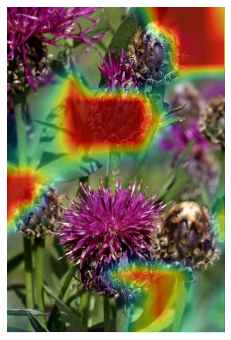

In [24]:
global_mean = np.nanmean(pmap, axis=(0,1))
print('Global mean pooled class_idx: {} ({:.2f}%)'.format(np.argmax(global_mean), np.max(global_mean)*100))

display_class_id = 1
utils.show_img_heatmap(img, utils.match_size(pmap[:,:,display_class_id], img) )

... and the highest probability `global_max` across the entire image along with the probability distribution for *Centaurea scabiosa*:

Global max pooled class_idx: 8 (99.99%)


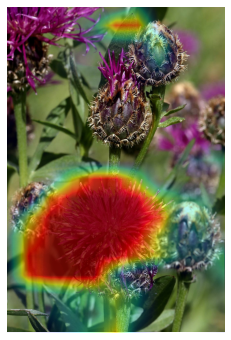

In [25]:
global_max = np.nanmax(pmap, axis=(0,1))
print('Global max pooled class_idx: {} ({:.2f}%)'.format(np.argmax(global_max), np.max(global_max)*100))

display_class_id = 8
utils.show_img_heatmap(img, utils.match_size(pmap[:,:,display_class_id], img) )

As expected, the network correctly predicts *Centaurea scabiosa* at the locations of the two blooming flower. However, the non-blooming flowers are misclassified as *Arctium tomentosum*. If you search for images of *Arctium tomentosum* using a search engine of your choice, you will understand why this is the case.

## 2.2 - Fully Convolutional Networks

In DL Lab 2.3, we discussed how ConvNets containing dense layers for classification can be transformed into Fully Convolutional Networks (FCNs) and how they could be used for simple object detection using a convolutional implementation of sliding windows. This way, a lot of computations can be shared which will considerably speed up the execution.

The basic idea of FCNs is to replace all dense layers with convolution layers. If input and output shapes as well as activation functions are kept constant, this replacement does not even affect the underlying mathematical operations. We can even re-use the weights of the dense layers!

In [26]:
print(classifier_model.summary())

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)      

You will use the output of layer `block5_pool (MaxPooling2D)` and stack new convolution layers on top. In order to re-use the weights of the `Dense` layers, you extract their weights by calling the `.get_weights()` method on them. Layer weights can then be set during layer definition by using the `weights` argument. However, the weight arrays need to be reshaped first!

**Task**: Complete the function `transform_to_fcn()` for converting the input classifier model `model` into a fully convolutional model.

**Hint**: Convolution layer weights have the shape $ f^{(l)} \times f^{(l)} \times n_f^{(l-1)} \times n_f^{(l)}$, where $f$ is the kernel size, $n_f$ the number of channels, and $(l)$ the layer index (check your DL Lab 2.1 notes).

**Hint$^2$**: In order to re-use the weights, the kernel shape $ f^{(l)} \times f^{(l)} \times n_f^{(l-1)}$ needs to match the output shape of the previous layer $n^{(l-1)} \times n^{(l-1)} \times n_f^{(l-1)}$.

**Hint$^3$**: The number of filters $n_f^{(l)}$ needs to match the number of outputs of the `Dense` layer to be replaced.

In [27]:
# GRADED FUNCTION: transform_to_fcn() (5 points)
def transform_to_fcn( model, input_shape=(150,150,3) ):

  # Create an instance of the VGG16 without top
  fcn_model = VGG16(input_shape=input_shape,
                    include_top=False)
  
  # Load the model weights into fcn_model
  for new_layer, layer in zip(fcn_model.layers[1:], model.layers[1:]):
    new_layer.set_weights(layer.get_weights()) 

  # Store output shape of block5_pool; NOTE: you can get a layer either by name or index
  block5_out_shape = model.get_layer("block5_pool").output.shape

  # Collect the dense layers
  dense_layers = [x for x in classifier_model.layers if 'Dense' in str(x.__class__)]

  # Extract weights and bias of the second last dense layer
  [dense_2_weights, dense_2_bias] = dense_layers[0].get_weights()

  # Extract weights and bias of the last dense layer
  [dense_1_weights, dense_1_bias] = dense_layers[1].get_weights()

  ### START YOUR CODE HERE ### (5 LOC)

  # Get output of the `block5_pool` layer for building a new top
  x = fcn_model.get_layer("block5_pool").output

  # Reshape the dense layer weights to fit the convolution layer weights shape
  dense_2_weights = dense_2_weights.reshape( block5_out_shape[1], block5_out_shape[2], block5_out_shape[3], dense_layers[1].input.shape[1] )
  print(dense_layers[1].output.shape, dense_layers[1].input.shape)
  print(dense_layers[1].activation)
  # Add convolution layer replacing the second last dense layer
  x = layers.Conv2D(filters=dense_layers[1].input.shape[1], 
                    kernel_size=[block5_out_shape[1], block5_out_shape[2]], 
                    activation= dense_layers[0].activation, 
                    weights=[dense_2_weights, dense_2_bias])(x)
  print(x.shape)
  # Reshape the weights to fit the convolution layer weights shape
  dense_1_weights = dense_1_weights.reshape(1, 1, 1024, 10)

  # Add convolution layer replacing the last dense layer
  fcn_output = layers.Conv2D(filters=10,
                             kernel_size=[1,1],
                             activation=dense_layers[1].activation,
                             weights=[dense_1_weights, dense_1_bias])(x)
  
  ### END YOUR CODE HERE ###
  
  # Add a GAP layer for global mean pooling across the spatial predictions
  mean_probabilities = layers.GlobalAveragePooling2D()(fcn_output)

  # Add a GMP layer for global max pooling across the spatial predictions
  max_probabilities = layers.GlobalMaxPooling2D()(fcn_output)

  # Define the fcn model to output the probability map and the mean- and max-pooled probabilities
  fcn_model = Model(inputs=fcn_model.input, 
                    outputs=[fcn_output, 
                             mean_probabilities, 
                             max_probabilities]
                    )
  
  return fcn_model

Now, transform the network into a FCN with an `input_shape` of `(448, 448, 3)`.

In [28]:
fcn_model = transform_to_fcn(classifier_model, input_shape=(448, 448, 3))
print(fcn_model.summary())

print('\nFCN output shape:', fcn_model.output_shape[0])
# expected output: FCN output shape: (None, 11, 11, 10)

(None, 10) (None, 1024)
<function softmax at 0x7f83f3d256a8>
(None, 11, 11, 1024)
Model: "functional_7"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 448, 448, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 448, 448, 64) 1792        input_2[0][0]                    
__________________________________________________________________________________________________
block1_conv2 (Conv2D)           (None, 448, 448, 64) 36928       block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_pool (MaxPooling2D)      (None, 224, 224, 64) 0           block1_conv2[0][0]               
_____

Now forward the image through the FCN:

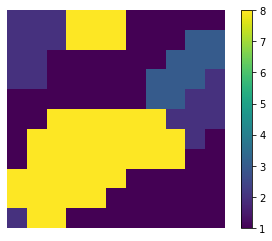

CPU times: user 544 ms, sys: 105 ms, total: 649 ms
Wall time: 650 ms


In [29]:
%%time
# Resize and normalize the image
img = img_to_array(test_img.resize( (448, 448) )) / 255.

# Forward image through network
pmap, global_mean, global_max = fcn_model.predict(np.expand_dims(img, 0) )

# Plot predicted label map
plt.imshow(np.argmax(pmap[0], axis=2))
plt.axis('Off')
plt.colorbar()
plt.show()

The label map should appear comparable to the label map computed by the traditional sliding window approach. Compare the execution times to get a sense of the speed up!

Also the probability map for *Arctium tomentosum* should be comparable to the results above:

Global mean pooled class_idx: 1 (39.78%)


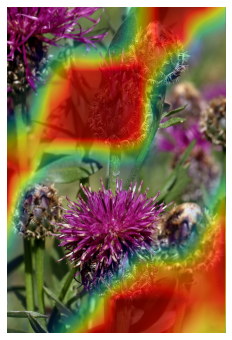

In [30]:
print('Global mean pooled class_idx: {} ({:.2f}%)'.format(np.argmax(global_mean), np.max(global_mean)*100))

img = img_to_array(test_img)/255.
display_class_id = 1
utils.show_img_heatmap(img, utils.match_size(pmap[0,:,:,display_class_id], img))

Same should apply to the probability map for *Centaurea scabiosa*:

Global max pooled class_idx: 8 (100.00%)


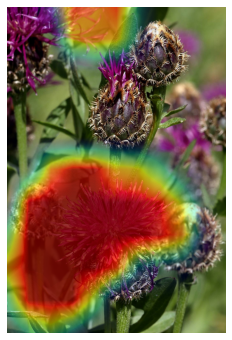

In [31]:
print('Global max pooled class_idx: {} ({:.2f}%)'.format(np.argmax(global_max), np.max(global_max)*100))

display_class_id = 8
utils.show_img_heatmap(img, utils.match_size(pmap[0,:,:,display_class_id], img))

In contrast to a model containing fully connected layers, the layer weights of a FCN do not depend on the input shape. Hence, you may build a FCN with arbitrary input shape using `None` as placeholder, and call it on images of arbitrary sizes:

(None, 10) (None, 1024)
<function softmax at 0x7f83f3d256a8>
(None, None, None, 1024)
image shape: (400, 267, 3)
Global max pooled class_idx: 8 (100.00%)


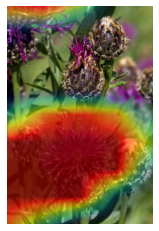

image shape: (534, 356, 3)
Global max pooled class_idx: 8 (100.00%)


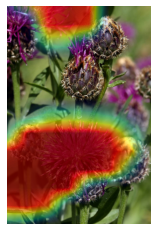

image shape: (800, 534, 3)
Global max pooled class_idx: 8 (99.98%)


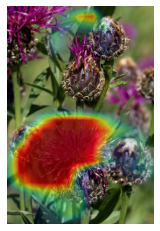

image shape: (1600, 1067, 3)
Global max pooled class_idx: 1 (100.00%)


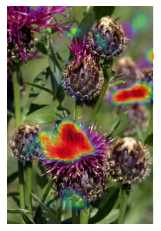

In [32]:
# FCN with arbitrary input shape
fcn_model = transform_to_fcn(classifier_model, input_shape=(None, None, 3))

for downscale in np.arange(1,5,1, dtype=int)[::-1]:

  # Resize and normalize the image, keep aspect ratio constant
  img = img_to_array(test_img.reduce(downscale)) / 255.
  print('image shape:', img.shape)

  # Forward image through network
  pmap, global_mean, global_max = fcn_model.predict(np.expand_dims(img, 0) )

  print('Global max pooled class_idx: {} ({:.2f}%)'.format(np.argmax(global_max), np.max(global_max)*100))

  display_class_id = 8
  utils.show_img_heatmap(img, utils.match_size(pmap[0,:,:,display_class_id], img), figsize=(4,4))
  plt.show()

Why does the predicted area for class 1 decreases as the image size increases?

**Task**: Write down your explanation in the next cell.

In [47]:
# GRADED EXPLANATION: (1 point)
"""
Because we have a more information about image with size increasing. 
Since smaller images are enlarged by adding zero-value pixels around their borders, the CNN will not sufficiently learn to extract features from the border areas, as well as it learns to do so in central areas.
"""

'\nBecause we have a more information about image with size increasing. \nSince smaller images are enlarged by adding zero-value pixels around their borders, the CNN will not sufficiently learn to extract features from the border areas, as well as it learns to do so in central areas.\n'

**Congratulations**! By transforming your classifier network into a FCN, you build an efficient model that can be used for detection and further interpretation of the results.

## 2.3 - Class Activation Mapping

Another approach for interpreting CNN predictions is to localize the largest activations of a certain class in the last convolutional feature map. By weighted mapping of this activation back to the input image, this simple but powerful method allows for highlighting the image areas most relevant for a class prediction. Hence, it also gives an estimate for objects' locations within an image. The method is termed **class activation mapping** (CAM) and was originally proposed by [Bolei Zhou et al. in 2016](https://www.cv-foundation.org/openaccess/content_cvpr_2016/html/Zhou_Learning_Deep_Features_CVPR_2016_paper.html).

The idea is to use a *global average pooling* (GAP) layer to reduce the dimensions $n_h \times n_w \times n_f$ of the 3D tensor containing the feature maps by computing the average of each feature map, i.e., reduce the dimensions to $1 \times 1 \times n_f$. 
Recall DL Labs 2.1 and 2.2, where you used a *global max pooling* layer prior to classification. I.e., instead of average feature maps, you computed the maximum value for each feature map in previous DL Labs. 

For CAM, the intuition behind the GAP layer is that each filter of the last convolution layer acts as a detector for a specific high-level object feature and their activation allow for localization in space. The GAP allows for efficient mapping between these feature maps and the last dense layer for classification.

**Task**: Complete the function `build_cam_model()` for making CAM modifications on a VGG16. Stack a GAP layer (provided by [`GlobalAveragePooling2D`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/GlobalAveragePooling2D)) on top of the last convolution layer. Finally, add a dense layer for classification. The number of classes is provided in `num_classes`. Compile the model using categorical crossentropy loss, Adam optimizer with learning rate 0.01, and accuracy as metric.

**Note**: The input shape is set to `(224, 224, 3)` for increasing the spatial resolution of the last feature maps to `(14, 14)`. 

In [34]:
# GRADED FUNCTION: build_cam_model (3 points)
def build_cam_model(num_classes, input_shape=(224, 224, 3), fine_tuned_model=None):

  pretrained_model = VGG16(input_shape=input_shape,
                           weights='imagenet',
                           include_top=False)
  
  if fine_tuned_model: # re-use the weights of the model we fine-tuned earlier
    print('using weights from "{}"'.format(fine_tuned_model.name))
    for new_layer, layer in zip(pretrained_model.layers[1:], fine_tuned_model.layers[1:]):
      new_layer.set_weights(layer.get_weights()) 

  ### START YOUR CODE HERE ### (≈3 LOC)

  # Use the output of the last convolution as input for the GAP
  x = layers.GlobalAveragePooling2D()(pretrained_model.layers[-2].output)

  # Add classification layer
  output = layers.Dense(num_classes, activation='softmax')(x)

  # Freeze the pretrained model
  pretrained_model.trainable = False
  
  ### END YOUR CODE HERE ###

  # Define the model
  cam_model = Model( pretrained_model.input, output )

  # Compile
  cam_model.compile(loss='categorical_crossentropy',
                    optimizer=Adam(lr=0.01),
                    metrics=['accuracy'])

  return cam_model

In [35]:
cam_model = build_cam_model(num_classes, fine_tuned_model=classifier_model, input_shape=(224, 224, 3))
assert np.array_equal( cam_model.layers[-3].output_shape, 
                      (None, 14, 14, 512) ), 'Wrong input shape or wrong input provided to the GAP layer'

print(cam_model.summary())

using weights from "functional_1"
Model: "functional_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPoo

Now train the CAM model for 5 epochs using the image generators with updated shapes.

Found 800 images belonging to 10 classes.
Found 200 images belonging to 10 classes.
Epoch 1/5
25/25 - 11s - loss: 1.1415 - accuracy: 0.8250 - val_loss: 0.3907 - val_accuracy: 0.9700
Epoch 2/5
25/25 - 10s - loss: 0.2881 - accuracy: 0.9862 - val_loss: 0.2099 - val_accuracy: 0.9600
Epoch 3/5
25/25 - 10s - loss: 0.1710 - accuracy: 0.9850 - val_loss: 0.1727 - val_accuracy: 0.9550
Epoch 4/5
25/25 - 11s - loss: 0.1255 - accuracy: 0.9862 - val_loss: 0.1541 - val_accuracy: 0.9550
Epoch 5/5
25/25 - 11s - loss: 0.0961 - accuracy: 0.9900 - val_loss: 0.1424 - val_accuracy: 0.9600


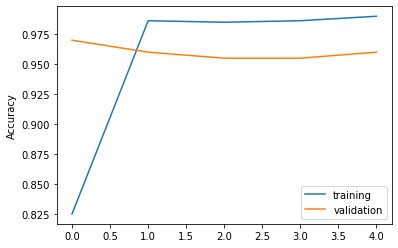

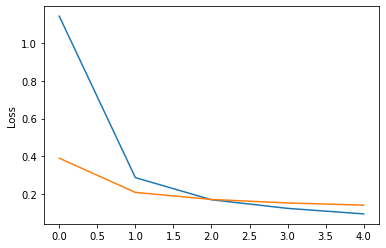

In [36]:
train_generator, validation_generator, train_steps, validation_steps, num_classes = utils.load_dataset('flowers10', image_shape=(224,224))

cam_hist = cam_model.fit(train_generator,
                         steps_per_epoch=train_steps,
                         epochs=5,
                         validation_data=validation_generator,
                         validation_steps=validation_steps,
                         verbose=2)

utils.plot_history(cam_hist)

The trained CAM model with GAP layer and classifier on top can now be used for class localization tasks. For localization, you need the feature maps just before the GAP layer. Every element in the GAP layer's output corresponds to one feature map. The connections between the feature maps and the predicted classes are actually the weights of last dense layer that you have just trained! The features important for prediction of a certain class are given higher weights. In result, to obtain a class activation map, you only need to compute the weighted sum of these feature maps.

To summarize, you need your CAM model to output
1. the predicted class probabilities,
2. the output of the last convolution layer, and
3. the weights of the dense layer for classification.

Based on your trained CAM model, you define a new model `vis_model` for returning these outputs.

**Task**: Complete the function `cam_visualization_model()` for returning the output of the last convolution layer along with the classifiers output.

In [37]:
# GRADED FUNCTION: cam_visualization_model (1 point)
def cam_visualization_model(cam_model):

  # Get the weights of the last fully connected layer
  weights,_ = cam_model.layers[-1].get_weights()

  # Define the vis_model to output the feature map AND the class probabilities
  
  ### START YOUR CODE HERE ### (≈ 1 LOC)
  vis_model = Model(
      inputs = cam_model.input,
      outputs = [cam_model.layers[-3].output, cam_model.output]
  )
  
  ### END YOUR CODE HERE ###

  return vis_model, weights

The function `compute_cam()` now computes the class activation map of a given image:

In [38]:
def compute_cam(img, vis_model, weights, class_idx=None):
  
  # Prepend batch dimension to image
  img = K.expand_dims(img, 0)
  
  # Forward image through visualization model
  feature_maps, class_predictions = vis_model.predict(img)

  # Remove preceding batch dimension
  feature_maps = K.squeeze(feature_maps, axis=0)
  class_predictions = K.squeeze(class_predictions, axis=0)

  if class_idx is None:
    # Get index of predicted class
    class_idx = np.argmax(class_predictions)
  
  # Upsample feature maps to original image size
  feature_maps = zoom(feature_maps, (16, 16, 1), order=1)
  
  # Compute weighted sum of activation maps for predicted class
  cam = np.dot( feature_maps, weights[:, class_idx] )

  cam = np.zeros(dtype=np.float32, shape=feature_maps.shape[0:2])
  for i, w in enumerate(weights[:, class_idx]):
    cam += w * feature_maps[:, :, i]

  return cam

CPU times: user 2.42 s, sys: 75.8 ms, total: 2.49 s
Wall time: 2.5 s


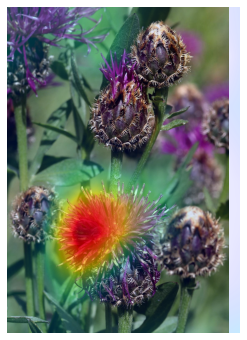

In [39]:
%%time
# Initialize an instance of the visualization model
vis_model, weights = cam_visualization_model(cam_model)

# Resize and normalize the image
img = img_to_array(test_img.resize( (224, 224) )) / 255.

# Compute the class activation map
cam = compute_cam(img, vis_model, weights, class_idx=8)

# Plot as heatmap overlaying the original image
img = img_to_array(test_img)/255.
utils.show_img_heatmap(img, utils.match_size(cam, img) )

Such spatially confined activations could be used for computing bounding boxes of the "detections":

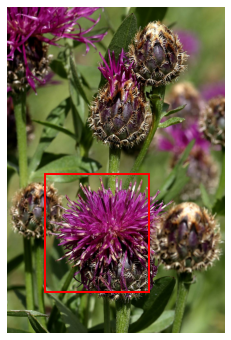

In [40]:
# Compute bounding box and plot on image
bboxes = utils.compute_bboxes(cam)
utils.show_img_bboxes(img_to_array(test_img)/255., bboxes)

In conclusion, **class activation mapping** can be used not only for interpreting a classifier output, but also for object localizatization by localizing classification-relevant parts of the objects in images. 

Keep in mind:
- Probability maps from FCNs as well as weighted feature maps from CAM have rather coarse spatial resolution and require upsampling to the original input size.
- In case of CAM, the binarization of the activation map for segmentation can be prone to errors. Hence, the bounding boxes sometimes don't fit very well.
- CAM highlights image regions relevant for classification, not entire objects!

However, you could use a method like CAM in order to generate bounding box annotations your images and then train a more sophisticated object detector, such as:

##2.4 - (Optional) YOLO - "You Only Look Once"

In DL Lab 2.3, we discussed a powerful family of models for efficient object detection: **You Only Look Once**, or YOLO, which was originally develoved by [Joseph Redmon et al. in 2015](https://arxiv.org/abs/1506.02640). Since the original publication, it has undergone a series of evolutionary steps. Here, you will be using its third incarnation, i.e., the *YOLOv3*.

The basic idea of YOLO is to use a Fully Convolutional Network (FCN) that predicts not only class probabilities per grid cell but also candidate bounding boxes depicting potential detections. Hence, the shape of the prediction kernel is $1 \times 1 \times ( N_\text{anchors} \times ( 5 + N_\text{classes} ) )$, where $N_\text{anchors}$ is the number of bounding boxes per cell and $N_\text{classes}$ the number of classes. Each predicted bounding box has 5 attributes: the 4 box coordinates (center coordinates, width, height) and one prediction confidence, i.e., a probability of the bounding box containing any object at all.

In [41]:
#@title Download YOLO source
download_file_from_google_drive('1udmTjGfkzOf4eD_AK7dX8erxpGq7LJLu', '/tmp/yolo.zip')
utils.unzip('/tmp/yolo.zip', '/content/')

unzipping to  /content/


In [42]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import Model
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import load_img, img_to_array

from matplotlib import pyplot as plt
from yolo import yolo_layers

In this example, you will restore weights of a YOLOv3 trained on the [Open Images v4](https://storage.googleapis.com/openimages/web/factsfigures_v4.html) dataset, which contains 600 classes (including "plant"). The weights are provided from [Joseph Redmon's website](https://pjreddie.com/darknet/yolo/) for the original YOLOv3 implementation and converted for Keras.

In [43]:
ckp_path = os.path.join('yolo', 'checkpoints', 'yolov3.tf')
class_names_path = 'yolo/openimages.names'

class_names = [c.strip() for c in open(class_names_path).readlines()]
num_classes = len(class_names)

img_path = 'testimage_detection.jpg'
test_img = load_img(img_path)

In *YOLOv3*, detections are computed at three different scales, i.e., using feature maps of three different sizes from three different depths within the network. To capture more fine-grained information, feature maps from earlier layers are concatenated to feature maps of deeper layers ahead of detection.
The underlying network (*Darknet-53*) uses 53 convolutional layers with residual skip connections.

In [44]:
def YoloV3(input_shape=(416,416,3), classes=500):

  anchors = yolo_layers.yolo_anchors
  masks = yolo_layers.yolo_anchor_masks

  x = inputs = layers.Input(input_shape)

  # Store outputs of layers x_36 and x_61
  x_36, x_61, x = yolo_layers.Darknet(name='yolo_darknet')(x)

  # Compute predictions at first scale
  x = yolo_layers.YoloConv(512, name='yolo_conv_0')(x)
  output_0 = yolo_layers.YoloOutput(512, len(masks[0]), classes, name='yolo_output_0')(x)

  # Concat output of layer x_61 and compute predictions at second scale
  x = yolo_layers.YoloConv(256, name='yolo_conv_1')((x, x_61))
  output_1 = yolo_layers.YoloOutput(256, len(masks[1]), classes, name='yolo_output_1')(x)
  
  # Concat output of layer x_36 and compute predictions at third scale
  x = yolo_layers.YoloConv(128, name='yolo_conv_2')((x, x_36))
  output_2 = yolo_layers.YoloOutput(128, len(masks[2]), classes, name='yolo_output_2')(x)

  # Transform boxes
  boxes_0 = layers.Lambda(lambda x: yolo_layers.yolo_boxes(x, anchors[masks[0]], classes),
                   name='yolo_boxes_0')(output_0)
  boxes_1 = layers.Lambda(lambda x: yolo_layers.yolo_boxes(x, anchors[masks[1]], classes),
                   name='yolo_boxes_1')(output_1)
  boxes_2 = layers.Lambda(lambda x: yolo_layers.yolo_boxes(x, anchors[masks[2]], classes),
                   name='yolo_boxes_2')(output_2)

  # Concat boxes from three scales and filter by threshold and non-max suppression
  outputs = layers.Lambda(lambda x: yolo_layers.yolo_nms(x, anchors, masks, classes),
                   name='yolo_nms')((boxes_0[:3], boxes_1[:3], boxes_2[:3]))

  return Model(inputs, outputs, name='yolov3')

In [45]:
# Initialize an instance of YOLO
yolo = YoloV3(classes=num_classes)

# Restore weights from network pre-trained on OpenImages
yolo.load_weights(ckp_path)

CPU times: user 769 ms, sys: 96.5 ms, total: 865 ms
Wall time: 742 ms


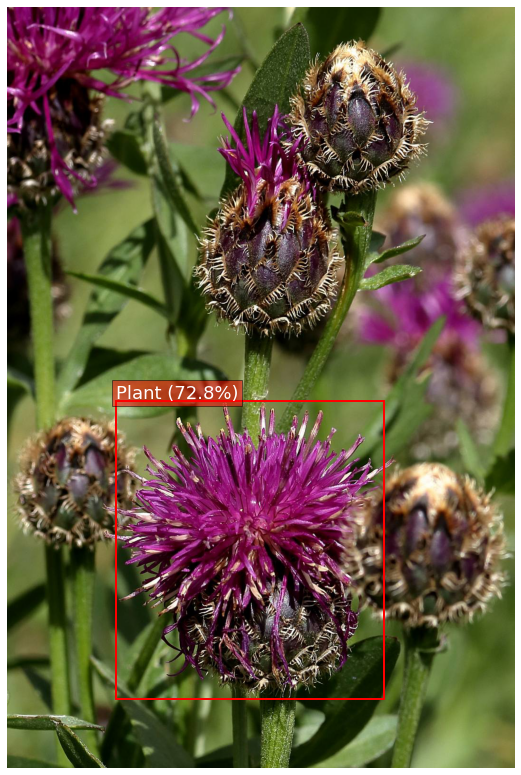

In [46]:
%%time
img = img_to_array(test_img.resize( (416, 416) )) / 255.
batch = tf.expand_dims(img, axis=0)

boxes, scores, classes, nums = yolo(batch)

bboxes = np.array([x for x in boxes[0] if not all(x==0)])
labels = list()
for idx,bbox in enumerate(bboxes):
  bbox[2] -= bbox[0]
  bbox[3] -= bbox[1]
  labels.append('{} ({:.1f}%)'.format(
      class_names[int(classes[0][idx])],
      scores[0][idx]*100))

utils.show_img_bboxes(img_to_array(test_img)/255., bboxes, labels=labels, figsize=(14,14))

---

# Congratulations on completing Assignment 2!

Complete the steps below for submission.

# Submission Instructions

You may now submit your notebook to moodle:
- Save the notebook (`CTRL`+ `s` or '*File*' -> '*Save*')
- Click on '*File*' -> '*Download .ipynb*' for downloading the notebook as IPython Notebook file.
- Upload the downloaded IPython Notebook file to **Moodle**.